In [9]:
import pandas as pd
from pathlib import Path
import yaml

In [28]:
root = Path("dataset/")
dataframes = {}
for p in root.rglob("*"):
    if p.is_dir() and "ipynb_checkpoints" not in str(p):
        with open(str(p)+"/metadata.yaml") as stream:
            try:
                metadata = yaml.safe_load(stream)
                trial_id = metadata["trial_id"]
                key = metadata["device"]["gpu_model"].replace("NVIDIA ","") + "_" + metadata["model"]["variant"]
                dataframes[key] = pd.read_csv(f"dataset/{trial_id}/data.csv")
            except yaml.YAMLError as exc:
                print(exc)
            except FileNotFoundError as exc:
                print(exc)

In [29]:
dataframes.keys()

dict_keys(['T4_M', 'ORIN_N', 'T4_X', 'ORIN_X', 'V100_M', 'V100_N', 'T4_N', 'ORIN_M', 'V100_X'])

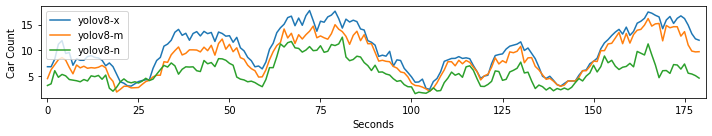

In [30]:
import matplotlib.pyplot as plt

ax = dataframes["T4_X"].groupby("timestamp")["car_count"].mean().reset_index()["car_count"][:60*3].plot(label="yolov8-x", figsize=(10, 2))
dataframes["T4_M"].groupby("timestamp")["car_count"].mean().reset_index()["car_count"][:60*3].plot(ax=ax, label="yolov8-m")
dataframes["T4_N"].groupby("timestamp")["car_count"].mean().reset_index()["car_count"][:60*3].plot(ax=ax, label="yolov8-n")

ax.set_xlabel("Seconds")
ax.set_ylabel("Car Count")
ax.legend()

# for ax in axes:
ax.margins(x=0.01)          # removes left and right padding
    
plt.tight_layout()
# fig = ax.get_figure()
# fig.savefig("accuracy_timeline.png", dpi=300, bbox_inches="tight")

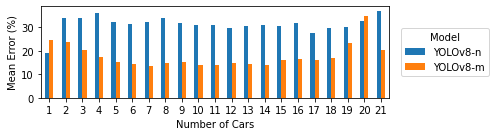

In [33]:
df_error = pd.concat(
    [
        dataframes["T4_X"].groupby("timestamp")["car_count"].mean().reset_index()["car_count"].rename("yolov8-x"),
        dataframes["T4_M"].groupby("timestamp")["car_count"].mean().reset_index()["car_count"].rename("yolov8-m"),
        dataframes["T4_N"].groupby("timestamp")["car_count"].mean().reset_index()["car_count"].rename("yolov8-n"),
    ],
    axis=1,
).reset_index()  # keeps timestamp as a column
df_error = df_error.dropna()
df_error["yolov8-m-error"] = abs(df_error["yolov8-x"] - df_error["yolov8-m"])/df_error["yolov8-x"]
df_error["yolov8-n-error"] = abs(df_error["yolov8-x"] - df_error["yolov8-n"])/df_error["yolov8-x"]
df_error["car_count_int"] = df_error['yolov8-x'].astype(int)

g = 100*df_error.groupby("car_count_int")[["yolov8-n-error", "yolov8-m-error"]].mean()

pretty = {
    "yolov8-n-error": "YOLOv8-n",
    "yolov8-m-error": "YOLOv8-m",
}

ax = g.rename(columns=pretty).plot(kind="bar", figsize=(7, 2))

ax.set_xlabel("Number of Cars")
ax.set_ylabel("Mean Error (%)")
ax.legend(title="Model")

# optional: change the x tick label formatting
ax.set_xticklabels([str(i) for i in g.index], rotation=0)
ax.legend(title="Model", loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
# fig = ax.get_figure()
# fig.savefig("errors.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Inference Latency')

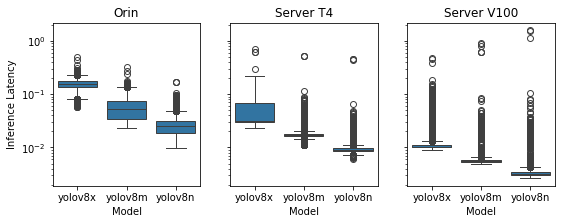

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

dfs = [
    (pd.concat([dataframes["ORIN_X"],   dataframes["ORIN_M"],   dataframes["ORIN_N"]],   ignore_index=True), "Orin"),
    (pd.concat([dataframes["T4_X"], dataframes["T4_M"], dataframes["T4_N"]], ignore_index=True), "Server T4"),
    (pd.concat([dataframes["V100_X"],dataframes["V100_M"],dataframes["V100_N"]],ignore_index=True), "Server V100"),
]

for ax, (df, title) in zip(axes, dfs):
    sns.boxplot(data=df, x="model", y="inf_latency", ax=ax)
    ax.set_xlabel("Model")
    ax.set_title(title)
    ax.set_yscale("log")  # <- log y-axis

axes[0].set_ylabel("Inference Latency")
# plt.tight_layout()
# fig.savefig("latency.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'GPU Utilization')

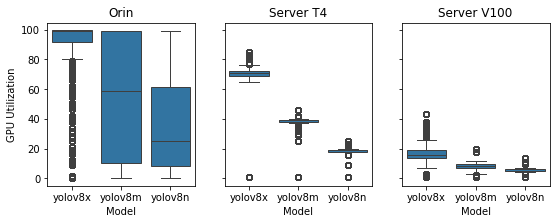

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

dfs = [
    (pd.concat([dataframes["ORIN_X"],   dataframes["ORIN_M"],   dataframes["ORIN_N"]],   ignore_index=True), "Orin"),
    (pd.concat([dataframes["T4_X"], dataframes["T4_M"], dataframes["T4_N"]], ignore_index=True), "Server T4"),
    (pd.concat([dataframes["V100_X"],dataframes["V100_M"],dataframes["V100_N"]],ignore_index=True), "Server V100"),
]

for ax, (df, title) in zip(axes, dfs):
    sns.boxplot(data=df, x="model", y="gpu_util", ax=ax)
    ax.set_xlabel("Model")
    ax.set_title(title)
    # ax.tick_params(axis="x")

axes[0].set_ylabel("GPU Utilization")
# plt.tight_layout()
# fig.savefig("utilization.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'GPU Power')

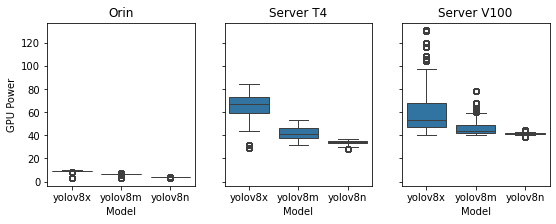

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

dfs = [
    (pd.concat([dataframes["ORIN_X"],   dataframes["ORIN_M"],   dataframes["ORIN_N"]],   ignore_index=True), "Orin"),
    (pd.concat([dataframes["T4_X"], dataframes["T4_M"], dataframes["T4_N"]], ignore_index=True), "Server T4"),
    (pd.concat([dataframes["V100_X"],dataframes["V100_M"],dataframes["V100_N"]],ignore_index=True), "Server V100"),
]

for ax, (df, title) in zip(axes, dfs):
    sns.boxplot(data=df, x="model", y="gpu_power", ax=ax)
    ax.set_xlabel("Model")
    ax.set_title(title)
    # ax.tick_params(axis="x")

axes[0].set_ylabel("GPU Power")
# plt.tight_layout()
# fig.savefig("power.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Energy per Inference (Joules)')

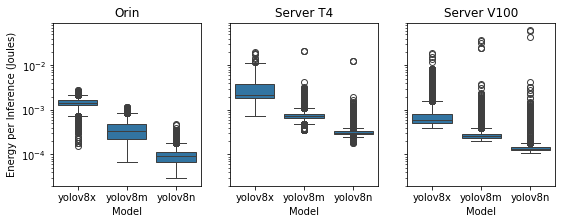

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

dfs = [
    (pd.concat([dataframes["ORIN_X"],   dataframes["ORIN_M"],   dataframes["ORIN_N"]],   ignore_index=True), "Orin"),
    (pd.concat([dataframes["T4_X"], dataframes["T4_M"], dataframes["T4_N"]], ignore_index=True), "Server T4"),
    (pd.concat([dataframes["V100_X"],dataframes["V100_M"],dataframes["V100_N"]],ignore_index=True), "Server V100"),
]

for ax, (df, title) in zip(axes, dfs):
    sns.boxplot(data=df, x="model", y=df["gpu_power"]*df["inf_latency"]/1000.0, ax=ax)
    ax.set_xlabel("Model")
    ax.set_title(title)
    # ax.tick_params(axis="x")
    ax.set_yscale("log")  # <- log y-axis


axes[0].set_ylabel("Energy per Inference (Joules)")
# plt.tight_layout()
# fig.savefig("energy.png", dpi=300, bbox_inches="tight")

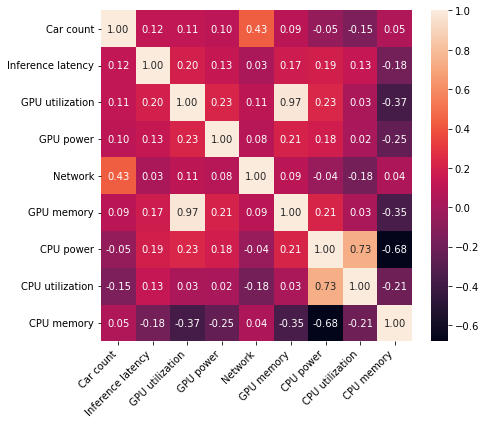

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fields = [
    "car_count","inf_latency","gpu_util","gpu_power","network",
    "gpu_mem","cpu_power","cpu_util","cpu_mem",
]

pretty = {
    "car_count":   "Car count",
    "inf_latency": "Inference latency",
    "gpu_util":    "GPU utilization",
    "gpu_power":   "GPU power",
    "network":     "Network",
    "gpu_mem":     "GPU memory",
    "cpu_power":   "CPU power",
    "cpu_util":    "CPU utilization",
    "cpu_mem":     "CPU memory",
}

df = pd.concat([
    dataframes["V100_X"].groupby("timestamp").mean(numeric_only=True), 
    dataframes["V100_M"].groupby("timestamp").mean(numeric_only=True), 
    dataframes["V100_N"].groupby("timestamp").mean(numeric_only=True)], 
               ignore_index=True)

corr = df[fields].rename(columns=pretty).corr(numeric_only=True)

plt.figure(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, fmt=".2f")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
# fig = ax.get_figure()
# fig.savefig("correlation.png", dpi=300, bbox_inches="tight")

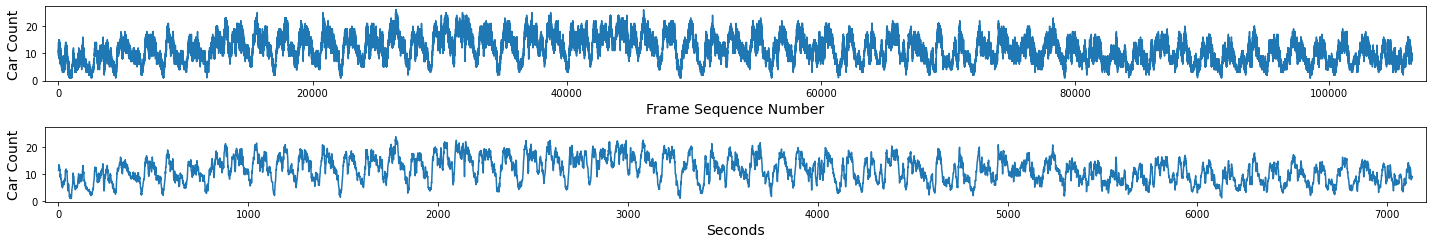

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(20, 3.5), sharey=True)

# 1) Car count vs frame sequence number
dataframes["V100_X"]["car_count"].plot(ax=axes[0])
axes[0].set_ylabel("Car Count", fontsize=14)
axes[0].set_xlabel("Frame Sequence Number", fontsize=14)

# 2) Mean car count per timestamp (seconds)
dataframes["V100_X"].groupby("timestamp")["car_count"].mean().reset_index().car_count.plot(ax=axes[1])
axes[1].set_ylabel("Car Count", fontsize=14)
axes[1].set_xlabel("Seconds", fontsize=14)

for ax in axes:
    ax.margins(x=0.01)          # removes left and right padding
    # ax.autoscale(enable=True, axis="x", tight=True)


plt.tight_layout()

# fig.savefig("car_count.png", dpi=300, bbox_inches="tight")